# Connecting Papers

In this notebook, we merge the retrieved and cleaned data from the previous steps.

We then create a new column that contains lists of eids that are part of my dataset.


In [4]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# inline
%matplotlib inline
import seaborn as sns

# Load the data.

article data and reference data


In [ ]:
p_df = "../data/02-clean/articles/scopus_cleaned_20250326.pkl"
df = pd.read_pickle(p_df)
print(df.shape)

p_refs = "../data/02-clean/references/eid_reference_dict_20250326.json"
with open(p_refs, "r") as f:
    eid_reference_dict = json.load(f)

(40643, 28)


map the number of references to each article based on the eid


In [6]:
df["reference_eids"] = df["eid"].map(eid_reference_dict)
print("Values for which no references were found:")
print(df[df["reference_eids"].isna()]["doi"].values)
print("Reason: Multiple conflicting entries in scopus")

# empty list for nan references
df["reference_eids"] = df["reference_eids"].fillna("[]")

# remove duplicates in reference_eids
df["reference_eids"] = df["reference_eids"].map(lambda x: list(set(x)))

Values for which no references were found:
['10.4088/PCC.15l01887' '10.1001/jama.2016.20614']
Reason: Multiple conflicting entries in scopus


number of references per article on averager and on average per year


In [7]:
# nr of references
df["nr_references"] = df["reference_eids"].map(lambda x: len(x))
print(f"Average number of references: {df['nr_references'].mean():.2f}")

Average number of references: 40.43


# Number of references per paper per year


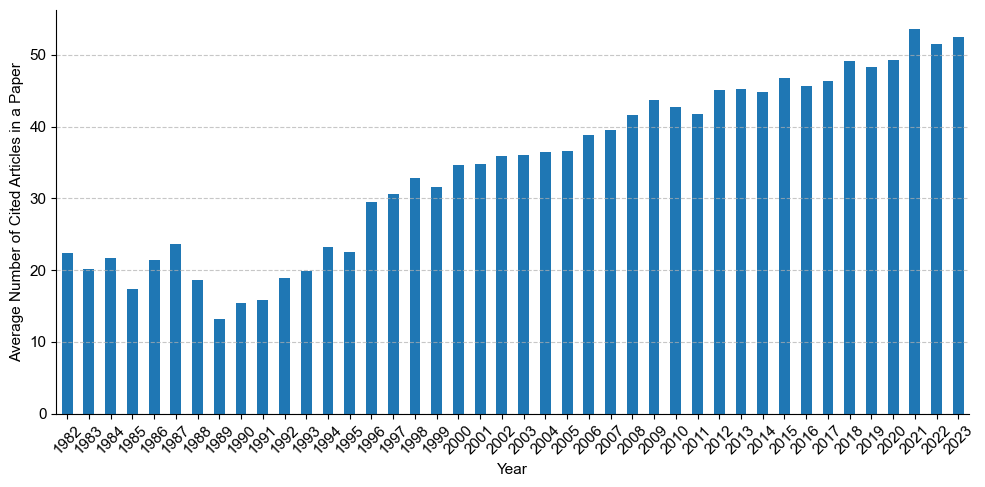

In [8]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})

# Group the DataFrame by the "year" column and calculate the mean of "nr_references" for each year
average_references_by_year = df.groupby("year")["nr_references"].mean()

# Plot the average number of references in a year
plt.figure(figsize=(10, 5))
average_references_by_year.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Cited Articles in a Paper"
)
plt.xticks(rotation=45)
# plt.title("Average Number of References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("../output/figures/total_average_references_by_year_20250326.png", dpi=300)
plt.show()

# Insample

## Number of links per paper per year


## connect papers


In [9]:
# Create a set of unique eids for faster membership checking
unique_eids = set(df["eid"].values)


# Function to filter "reference_eids" based on "eid" column
def filter_reference_eids(reference_eids, unique_eids):
    return list(set([eid_ref for eid_ref in reference_eids if eid_ref in unique_eids]))


# Apply the filter function to create a new column
df["filtered_reference_eids"] = df["reference_eids"].apply(
    filter_reference_eids, args=(unique_eids,)
)

# nr of references after filtering
df["nr_filtered_references"] = df["filtered_reference_eids"].map(lambda x: len(x))
print(
    f"Average number of filtered references: {df['nr_filtered_references'].mean():.2f}"
)

Average number of filtered references: 8.87


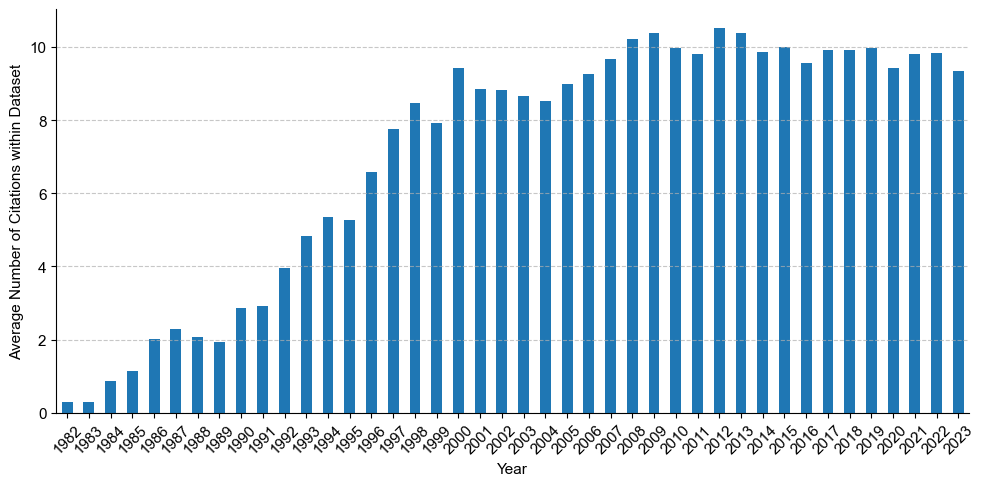

In [10]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})
# plot the average number of filtered references in a year
average_filtered_references_by_year = df.groupby("year")[
    "nr_filtered_references"
].mean()
plt.figure(figsize=(10, 5))
average_filtered_references_by_year.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Citations within Dataset"
)

# rotate xticks
plt.xticks(rotation=45)
# plt.title("Average Number of Filtered References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# remove top and right spines
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("../output/figures/insample_average_references_by_year_20250326.png", dpi=300)
plt.show()

## create descriptes dataframe


In [11]:
# create dataframe with year and average number of references and average number of filtered references
nr_references_descriptive_df = pd.DataFrame({
    "year": average_references_by_year.index,
    "average_references": average_references_by_year.values,
    "average_insample_references": average_filtered_references_by_year.values
})

path = "../output/tables/descriptives/nr_references_descriptive_df_20250326.csv"

nr_references_descriptive_df.to_csv(path, index=False)


# Save dataframe


In [12]:
df.to_pickle("../data/03-connected/scopus_cleaned_connected_20250326.pkl")